# Assigment 2 - Forecasting Electricity Prices

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import Markdown as md
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm
from math import sqrt
import warnings
import numpy as np
import os
import pandas as pd
import datetime as dt

warnings.filterwarnings("ignore")

Loading in required data, and filtering according to requirements.

In [2]:
file_P = os.path.join(os.getcwd(),'data/Elspotprices2.csv')
df_prices = pd.read_csv(file_P)
df_prices["HourUTC"] = pd.to_datetime(df_prices["HourUTC"])
df_prices = df_prices.loc[(df_prices['PriceArea']=="DK2")][["HourUTC","SpotPriceDKK"]]
df_prices = df_prices.loc[df_prices["HourUTC"].dt.year.isin([2019,2020,2021,2022,2023])]
df_prices = df_prices.reset_index(drop=True)

## Task 1
Develop an ARIMA model to predict electricity prices. Your goal in all following tasks is to achieve the best possible performance. In both sub-tasks report the RMSE values you achieve with your models.


### 1.1 
Use NO exogenous variables in your model and make day-ahead prediction for your testing dataset. You can use a seasonal ARIMA or FourierFeaturizer and any data transformation you want in your model, but no exogenous features from df data. Establish a suitable persistence forecast and report the RMSE values in both cases (your model and  persistence). Briefly discuss your results.

We start by dividing the data into training- and test sets.

In [3]:
# We use the time intervial.
t_s_train = pd.Timestamp(dt.datetime(2019, 1, 1, 0, 0, 0))
t_e_train = pd.Timestamp(dt.datetime(2023, 11, 30, 23, 0, 0))

train = df_prices.loc[(df_prices['HourUTC'] >= t_s_train) & (df_prices['HourUTC'] <= t_e_train)]
train = train.reset_index(drop=True)

t_s_test = pd.Timestamp(dt.datetime(2023, 12, 1, 0, 0, 0))
t_e_test= pd.Timestamp(dt.datetime(2023, 12, 31, 23, 0, 0))

test = df_prices.loc[(df_prices['HourUTC'] >= t_s_test) & (df_prices['HourUTC'] <= t_e_test)]
test = test.reset_index(drop=True)

We will plot the two sets besides each other

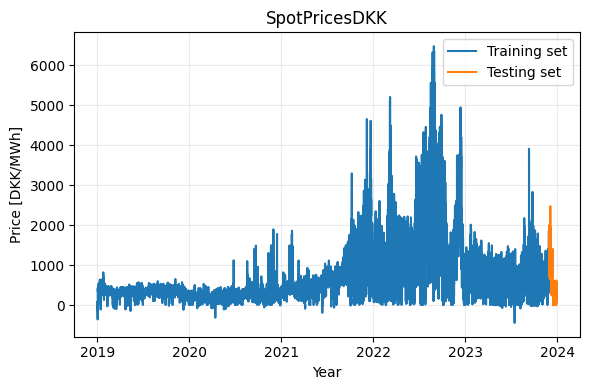

In [4]:

plt.figure(figsize=(6, 4), dpi=100)

plt.plot(train['HourUTC'], train['SpotPriceDKK'])
plt.plot(test['HourUTC'], test['SpotPriceDKK'])

plt.title('SpotPricesDKK')
plt.xlabel('Year')
plt.ylabel('Price [DKK/MWh]')

plt.legend(["Training set", "Testing set"])
plt.tight_layout()
plt.grid(alpha=0.25)
plt.show()

We will use a method that automatically fits the best model for us. We will first remove all the columns other than the numericals values for SpotPricesDKK.

In [5]:
# Convert training- and test sets to lists
train_Arima = train['SpotPriceDKK']
test_Arima = test['SpotPriceDKK']

# Automatically fit the ARIMA model
# model = pm.auto_arima(train_Arima, seasonal = True, trace = True, maxiter = 5, stepwise = True, method = 'nm')
model = pm.arima.ARIMA(order=(5, 1, 0))
model.fit(test_Arima)

ARIMA(order=(5, 1, 0))

In [6]:
# Day-ahead prediction
pred = []

for i in range(0, len(test_Arima), 24):
    # Predict next 24 values for all time series at once
    pred_temp = model.predict(24)
    pred.extend(pred_temp)
    
    # Update model with actual values for the next 24 time steps in one go
    model.update(test_Arima[i:i+24])

For comparison, a simple persistence model is created.

In [7]:
pers = np.zeros(len(test_Arima)).tolist()

for i in range(24, len(test_Arima), 24):
    for j in range(24):
        pers[i+j] = test_Arima[(i-24)+j]

The test data is plotted along with the ARIMA(5,1,0) predictions and the persistence model.

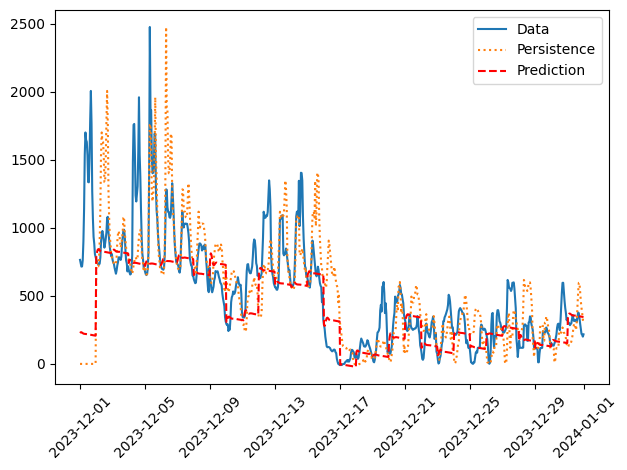

In [8]:
plt.figure()
plt.plot(test['HourUTC'], test_Arima, label='Data')
plt.plot(test['HourUTC'], pers, label='Persistence', linestyle="dotted")
plt.plot(test['HourUTC'], pred, label='Prediction', linestyle="dashed", color="red")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The error metrics for both are calculated.

In [9]:
# Calculate error metrics
RMSE_AR_pred = sqrt(mean_squared_error(test_Arima, pred))
MAE_AR_pred = mean_absolute_error(test_Arima, pred)
print('Prediction')
print('\t Root-mean-square error: ', round(RMSE_AR_pred,2))
print('\t Mean absolute error: ', round(MAE_AR_pred,2))

print('')

RMSE_AR_pers = sqrt(mean_squared_error(test_Arima, pers))
MAE_AR_pers = mean_absolute_error(test_Arima, pers)
print('Persistence')
print('\t Root-mean-square error: ', round(RMSE_AR_pers,2))
print('\t Mean absolute error: ', round(MAE_AR_pers,2))

Prediction
	 Root-mean-square error:  317.12
	 Mean absolute error:  199.06

Persistence
	 Root-mean-square error:  339.24
	 Mean absolute error:  214.76


This shows that the day-ahead prediction with no exogenous variables is only slightly better than simply assuming the same values as the previous day.

### 1.2
Add any exogenous variables you want (maximum 3) and repeat the process (choose/optimize
your model and evaluate it for the day-ahead prediction). What exogenous variables helped you improve the prediction and how did you choose the specific ones? Report the RMSE value and compare your results with those from task 1.1 and briefly discuss them.

Loading in the data with exogenous variables.

In [10]:
file_P = os.path.join(os.getcwd(),'data/ProdConData.csv')
df_data = pd.read_csv(file_P)
df_data["HourUTC"] = pd.to_datetime(df_data["HourUTC"])
df_data = df_data.loc[df_data["HourUTC"].dt.year.isin([2019,2020,2021,2022,2023])]
df_data = df_data.loc[df_data["PriceArea"].isin(["DK2"])]
df_data = df_data.reset_index(drop=True)

In [11]:
# Which variables do we have to choose from?
for col in df_data.columns:
    print(col)

HourUTC
HourDK
PriceArea
CentralPowerMWh
LocalPowerMWh
CommercialPowerMWh
LocalPowerSelfConMWh
OffshoreWindLt100MW_MWh
OffshoreWindGe100MW_MWh
OnshoreWindLt50kW_MWh
OnshoreWindGe50kW_MWh
HydroPowerMWh
SolarPowerLt10kW_MWh
SolarPowerGe10Lt40kW_MWh
SolarPowerGe40kW_MWh
SolarPowerSelfConMWh
UnknownProdMWh
ExchangeNO_MWh
ExchangeSE_MWh
ExchangeGE_MWh
ExchangeNL_MWh
ExchangeGB_MWh
ExchangeGreatBelt_MWh
GrossConsumptionMWh
GridLossTransmissionMWh
GridLossInterconnectorsMWh
GridLossDistributionMWh
PowerToHeatMWh


Expecting offshore wind generation to be the largest producer, it is chosen, alongside the biggest import for today's date, 10/04/2024, being Sweden. Lastly, the gross energy consumption is chosen, as it is expected to have an impact on the hourly energy price due to peak hours.

In [12]:
test.insert(1, "Offshore_Gen", df_data["OffshoreWindGe100MW_MWh"])
test.insert(2, "Exchange_SE", df_data["ExchangeSE_MWh"])
test.insert(3, "Consumption", df_data["GrossConsumptionMWh"])

In [13]:
model.fit(test_Arima, X = pd.DataFrame(test[test.columns[1:4]]))
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  744
Model:               SARIMAX(5, 1, 0)   Log Likelihood               -4367.126
Date:                Wed, 10 Apr 2024   AIC                           8754.252
Time:                        11:41:33   BIC                           8800.359
Sample:                             0   HQIC                          8772.026
                                - 744                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -1.1506      4.477     -0.257      0.797      -9.926       7.625
Offshore_Gen     0.0514      0.078      0.662      0.508      -0.101       0.204
Exchange_SE      0.0108      0.012      0.907      0.364      -0.013       0.034
Consumption      0.3197      0.045      7.123      0.000       0.232       0.408
ar.L1            0.1865      0.012     16.194      0.000       0.164       0.209
ar.L2           -0.0510      0.021     -2.488      0.013      -0.091      -0.011
ar.L3           -0.1214      0.030     -4.037      0.000      -0.180      -0.062
ar.L4           -0.1281      0.040     -3.187      0.001      -0.207      -0.049
ar.L5           -0.0529      0.036     -1.452      0.147      -0.124       0.019
sigma2        7494.9437    109.879     68.211      0.000    7279.584    7710.303
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             42038.64
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                             1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 2.1 

Her er Mads Version

In [14]:
# Import of data manipulation / visualization libraries
import os
import pandas as pd
import numpy as np

# Import of data visualization libraries
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# Import of data preprocessing libraries
from sklearn.preprocessing import MinMaxScaler

# Import of tensorflow libraries
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
# from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

In [15]:
# We load the spot prices
file_Path = os.path.join(os.getcwd(),'Elspotprices2.csv')
df_prices = pd.read_csv(file_Path)

# We convert the HourUTC column to datetime and set the column only at the DK2 price area
df_prices["HourUTC"] = pd.to_datetime(df_prices["HourUTC"])
df_prices = df_prices.loc[(df_prices['PriceArea']=="DK2")][["HourUTC","SpotPriceDKK"]]
df_prices = df_prices.loc[df_prices["HourUTC"].dt.year.isin([2019,2020,2021,2022,2023])]
df_prices = df_prices.reset_index(drop=True)

# We load the production and consumption data
file_Path = os.path.join(os.getcwd(),'ProdConData.csv')
df_data = pd.read_csv(file_Path)

# "e convert the HourUTC column to datetime
df_data["HourUTC"] = pd.to_datetime(df_data["HourUTC"])
df_data = df_data.loc[df_data["HourUTC"].dt.year.isin([2019,2020,2021,2022,2023])]
df_data = df_data.reset_index(drop=True)

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\marci\\Documents\\GitHub\\EnergyAnalytics_2\\Elspotprices2.csv'

Now we need to create a training data set from our data. Here we will be using the data for the DK2 spot price from 1/1-2019 - 30/11-2023.


In [ ]:
# We set up the starting date and the ending date for the training data
start_date = pd.to_datetime('2019-01-01 00:00:00')
end_date = pd.to_datetime('2023-11-30 23:00:00')
training_df_prices = df_prices[(df_prices['HourUTC'] >= start_date) & (df_prices['HourUTC'] <= end_date)]

# We create the new dataframe for the training data
training_data = pd.DataFrame({'DateTime': training_df_prices['HourUTC'], 'DK2Prices': training_df_prices['SpotPriceDKK']})

# We can plot the training data
training_data.plot(x='DateTime', y='DK2Prices', kind='line')
plt.xlabel('DateTime')
plt.ylabel('DK2Prices')
plt.title('Training Data')
plt.show()

In [ ]:
# We create the scaled values of the spotprices
scaler = MinMaxScaler()
# fit the format of the scaler -> convert shape from (1000, ) -> (1000, 1)
SpotPriceDKK = training_df_prices.SpotPriceDKK.values.reshape(-1, 1)
scaled_SpotPriceDKK = scaler.fit_transform(SpotPriceDKK)

seq_len = 25

# We we can define the function for splitting the data into sequences
def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

# And for splitting the data into training and test sets
def get_train_test_sets(data, seq_len, train_frac):
    sequences = split_into_sequences(data, seq_len)
    n_train = int(sequences.shape[0] * train_frac)
    x_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, :]
    x_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, :]
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_train_test_sets(scaled_SpotPriceDKK, seq_len, train_frac=0.9)

In [ ]:
# fraction of the input to drop; helps prevent overfitting
dropout = 0.2
window_size = seq_len - 1

# build a 3-layer LSTM RNN
model = keras.Sequential()

model.add(
    LSTM(window_size, return_sequences=True, 
         input_shape=(window_size, x_train.shape[-1]))
)

model.add(Dropout(rate=dropout))
# Bidirectional allows for training of sequence data forwards and backwards
model.add(
    Bidirectional(LSTM((window_size * 2), return_sequences=True)
)) 

model.add(Dropout(rate=dropout))
model.add(
    Bidirectional(LSTM(window_size, return_sequences=False))
) 

model.add(Dense(units=1))
# linear activation function: activation is proportional to the input
model.add(Activation('linear'))


batch_size = 16

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    x_train,
    y_train,
    epochs=1,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.05
)

In [ ]:
# Initialize an empty list to store the predicted and actual prices
predicted_prices = []
actual_prices = []

# Loop through 30 days
for _ in range(30):
    # Predict the prices for the next 24 hours
    y_pred = model.predict(x_test[:24])
    
    # Invert the scaler to get the absolute price data
    y_test_orig = scaler.inverse_transform(y_test[:24])
    y_pred_orig = scaler.inverse_transform(y_pred)
    
    # Append the predicted and actual prices to the respective lists
    predicted_prices.append(y_pred_orig)
    actual_prices.append(y_test_orig)
    
    # Update x_test for the next 24 hours prediction
    x_test = np.concatenate([x_test[24:], y_pred.reshape(1, 24, 1)], axis=0)
    y_test = np.concatenate([y_test[24:], y_test[:24]], axis=0)

# Plot the predicted and actual prices for 30 days
plt.figure(figsize=(12, 6))
for i in range(30):
    plt.plot(np.arange(i*24, (i+1)*24), actual_prices[i], color='orange', linewidth=0.5)
    plt.plot(np.arange(i*24, (i+1)*24), predicted_prices[i], color='green', linewidth=0.5)

plt.title('SpotPriceDKK Hourly Prices Predicted 24 at a time for 30 days')
plt.xlabel('Hours')
plt.ylabel('Price (DKK/MWh)')
plt.legend(['Actual Price', 'Predicted Price'])
plt.show()